## Importing the required libraries

In [228]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [229]:
from keras import regularizers

In [230]:
import os

In [231]:
mylist= os.listdir('c:/Users/Apratim/Documents/Speech-Emotion-Analyzer-master/rawdata')

In [232]:
type(mylist)

list

In [233]:
print(mylist[900])

03-02-06-01-02-02-04.wav


In [234]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [235]:
data, sampling_rate = librosa.load('c:/Users/Apratim/Documents/Speech-Emotion-Analyzer-master/rawdata/03-02-06-01-02-02-04.wav')

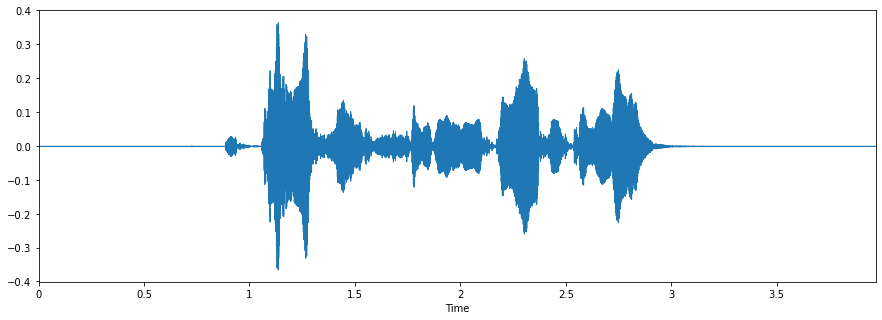

In [236]:

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

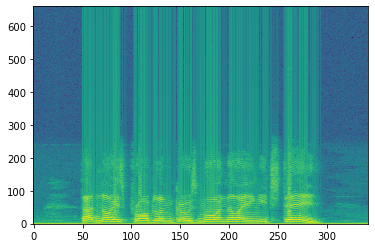

In [237]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('c:/Users/Apratim/Documents/Speech-Emotion-Analyzer-master/rawdata/h06.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [238]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    elif item[:1]=='n':
        feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [239]:
labels = pd.DataFrame(feeling_list)

In [240]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [241]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('c:/Users/Apratim/Documents/Speech-Emotion-Analyzer-master/rawdata/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [242]:
df[:5]

,feature
0,"[-61.54295510658346, -61.670296754068936, -61...."
1,"[-59.344055175803504, -59.344055175803504, -59..."
2,"[-48.9544987427011, -48.82861517966868, -49.68..."
3,"[-60.07603647808028, -60.313335914843364, -59...."
4,"[-60.014854603951115, -62.68690033925569, -65...."


In [243]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [244]:
newdf = pd.concat([df3,labels], axis=1)

In [245]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [246]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-32.029650,-28.536739,-27.502652,-26.418862,-27.831207,-28.752036,-28.786452,-21.615861,-17.308698,male_calm
1,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,...,-42.964803,-43.955095,-44.208014,-43.749871,-42.165373,-43.236346,-43.611909,-20.658559,-12.422126,female_calm
2,-48.954499,-48.828615,-49.681607,-52.032167,-48.399128,-47.975902,-49.650617,-51.260967,-49.758039,-50.975235,...,-23.577653,-24.113671,-22.895823,-22.712570,-24.839601,-27.322341,-28.557564,-28.592688,-25.435740,male_calm
3,-60.076036,-60.313336,-59.857057,-57.803318,-58.947750,-59.264010,-57.992623,-57.401937,-57.059823,-57.166067,...,-42.776788,-40.195332,-38.818478,-39.010697,-41.907329,-42.493783,-43.464285,-36.841318,-29.907367,female_calm
4,-60.014855,-62.686900,-65.488106,-60.481269,-60.038140,-64.788395,-66.386250,-61.152503,-58.949653,-59.597212,...,-43.592583,-42.287832,-42.087951,-42.331040,-40.317863,-37.837947,-35.932857,-32.704999,-28.022448,male_calm


In [247]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
459,-62.299694,-62.338424,-62.621848,-62.329484,-61.454263,-61.094933,-61.070457,-61.927559,-61.730643,-61.823694,...,-46.073412,-46.657304,-47.918686,-48.356712,-47.317767,-46.662255,-48.665217,-36.969883,-29.968863,female_sad
736,-57.906775,-57.906775,-57.906775,-57.906775,-57.906775,-57.906775,-57.906775,-57.906775,-57.995983,-58.301848,...,-25.764357,-28.052028,-28.587883,-29.994153,-29.487796,-28.748436,-27.663622,-19.329586,-14.170833,male_fearful
361,-46.986481,-46.792430,-46.612442,-46.630119,-45.646877,-46.305901,-47.200599,-46.614090,-47.392817,-47.315747,...,-19.993810,-19.173664,-19.085763,-20.418126,-19.544734,-20.263163,-20.613767,-10.640032,-5.008471,male_happy
693,-47.492827,-47.492827,-47.492827,-47.766825,-47.813619,-47.714531,-47.492827,-47.492827,-47.492827,-47.492827,...,-38.946291,-40.175103,-38.856046,-38.880433,-41.370138,-40.926647,-41.654234,-38.115638,-30.628546,female_angry
1138,-28.023489,-27.012539,-24.843077,-26.073845,-26.605960,-25.415706,-26.137463,-25.882579,-26.144014,-25.486000,...,-9.060266,-10.795528,-11.224794,-10.564187,-10.653920,-10.423875,-10.612708,-9.730200,-6.192753,neutral
1004,-13.442277,-8.020599,-5.986820,-6.373723,-5.190186,-4.239274,-3.880402,-8.047453,-14.418951,-16.864241,...,-10.693924,-10.625392,-10.843582,-10.529746,-9.981357,-10.076419,-9.949385,-4.860997,-0.177100,male_fearful
580,-51.967466,-51.584417,-51.798072,-52.369677,-51.502517,-51.277643,-50.542725,-49.925582,-49.461802,-49.851299,...,-49.206691,-48.070279,-47.589722,-47.555319,-48.926231,-47.952118,-47.559419,-28.053577,-19.832642,female_angry
372,-60.319421,-57.927886,-56.411374,-57.332663,-62.667894,-62.667894,-62.655617,-61.638654,-60.512968,-58.764566,...,-26.263934,-23.401128,-22.573800,-22.647447,-21.094450,-21.253368,-22.356263,-22.346596,-18.993974,male_sad
88,-48.555369,-48.241783,-48.197862,-48.108751,-47.929091,-47.488936,-48.715798,-50.933378,-50.388829,-48.981814,...,-24.049373,-24.099370,-24.216188,-24.134638,-23.827174,-24.043517,-23.246691,-12.605949,-7.628912,male_calm
53,-51.352334,-51.739854,-51.824799,-51.898362,-53.880815,-55.147142,-56.017255,-57.151358,-53.582647,-52.549508,...,-44.520123,-48.110992,-48.306104,-49.382074,-49.741433,-47.963893,-49.856042,-48.339909,-48.574673,female_calm


In [248]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [249]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [250]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
284,-55.103138,-55.768955,-55.017882,-54.408313,-55.773327,-56.602172,-56.307942,-55.359773,-55.884826,-56.530997,...,-31.022344,-30.601650,-30.346034,-29.532923,-29.932635,-30.371321,-30.594184,-26.583631,-21.060909,male_happy
830,-39.232888,-40.196653,-41.928357,-40.342907,-40.660466,-43.610679,-42.578229,-42.616471,-42.740492,-42.395479,...,-18.223313,-18.529134,-16.491401,-17.392898,-17.213515,-18.019388,-18.077181,-14.640167,-10.890690,male_fearful
474,-53.052554,-52.273537,-52.967513,-55.345626,-55.556668,-53.445201,-51.471059,-51.712280,-53.809481,-55.181184,...,-37.994365,-39.485830,-39.067747,-33.886137,-32.327182,-28.574870,-25.577641,-24.497021,-20.466448,male_sad
431,-53.307519,-53.641110,-53.741404,-54.233621,-54.959453,-56.191356,-56.465055,-55.068571,-54.944490,-56.470620,...,-33.084378,-32.807436,-34.329329,-33.652487,-32.901402,-32.707682,-32.379341,-24.389444,-19.652568,male_sad
667,-37.625122,-36.502180,-36.284159,-35.003262,-35.008088,-33.986679,-34.470556,-35.709850,-36.329798,-36.851007,...,-23.599941,-24.584728,-25.418156,-28.237317,-20.587273,-14.192994,-13.168046,-13.368124,-9.639316,male_angry
904,-48.726505,-49.000297,-48.125123,-47.818618,-46.961585,-47.177824,-49.321729,-49.567275,-49.075959,-48.049323,...,-42.958969,-41.582054,-40.271711,-41.451340,-41.399405,-41.075464,-40.421840,-22.951289,-14.262777,female_fearful
63,-62.422375,-62.422375,-62.422375,-62.421884,-61.255772,-59.411751,-61.613455,-62.422375,-59.265352,-59.147352,...,-28.334983,-28.135575,-27.501766,-27.712266,-27.320934,-28.133856,-29.402639,-22.156208,-16.097927,male_calm
69,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.151587,-59.149453,-58.931153,...,-32.370957,-31.170328,-28.492162,-26.996384,-26.160202,-26.592119,-27.137036,-21.495017,-16.727303,male_calm
254,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,-55.819379,...,-48.054330,-49.525808,-47.774363,-48.026914,-48.004212,-47.202254,-48.594571,-30.843806,-22.808237,female_happy
1077,-32.891751,-28.499278,-26.036026,-25.475705,-25.329830,-25.574585,-26.843114,-27.700156,-27.972555,-30.287525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_happy


In [251]:
trainfeatures = train.iloc[:, :-1]

In [252]:
trainlabel = train.iloc[:, -1:]

In [253]:
testfeatures = test.iloc[:, :-1]

In [254]:
testlabel = test.iloc[:, -1:]

In [255]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\Apratim\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [256]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [257]:
X_train.shape

(1028, 216)

## Changing dimension for CNN model

In [258]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [259]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [260]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_28 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_29 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 27, 128)          

In [261]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [262]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=216, epochs=700, validation_data=(x_testcnn, y_test))

ValueError: Error when checking target: expected activation_32 to have shape (1,) but got array with shape (11,)

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [263]:
model_name = 'Emotion_Voice_Detection.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Apratim\Documents\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection.h5 


In [264]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [265]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


ValueError: Error when checking target: expected activation_32 to have shape (10,) but got array with shape (11,)

## Predicting emotions on the test data

In [266]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

252/252 [==============================] - 0s 1ms/step


In [267]:
preds

array([[0.04575441, 0.02362601, 0.01034733, ..., 0.55856544, 0.03258894,
        0.09349865],
       [0.05241719, 0.03201839, 0.02737035, ..., 0.46988243, 0.04287628,
        0.09228508],
       [0.10256148, 0.05303528, 0.06858587, ..., 0.22721198, 0.09542985,
        0.10007318],
       ...,
       [0.04054949, 0.02556581, 0.01515848, ..., 0.52823347, 0.02448588,
        0.08334105],
       [0.04392938, 0.03413314, 0.02087248, ..., 0.48790324, 0.02949691,
        0.09292997],
       [0.09865071, 0.05925719, 0.08350907, ..., 0.15050691, 0.05517829,
        0.16640735]], dtype=float32)

In [268]:
preds1=preds.argmax(axis=1)

In [269]:
preds1

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 0, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 0, 7, 7, 7,
       7, 7, 7, 0, 7, 0, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 0, 7, 7, 7, 0, 7, 0, 7, 7, 7, 7,
       7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 0, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 0, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 0, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 9], dtype=int64)

In [270]:
abc = preds1.astype(int).flatten()

In [271]:
predictions = (lb.inverse_transform((abc)))

In [272]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_fearful
1,male_fearful
2,male_fearful
3,male_fearful
4,male_fearful
5,male_fearful
6,male_fearful
7,male_fearful
8,male_fearful
9,male_fearful


In [273]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [274]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_angry
1,male_sad
2,male_angry
3,male_angry
4,female_fearful
5,female_sad
6,male_fearful
7,neutral
8,male_calm
9,male_angry


In [275]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [276]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_fearful,male_fearful
21,female_calm,male_fearful
22,female_angry,male_fearful
23,male_fearful,male_fearful
24,female_calm,male_fearful
25,male_calm,male_fearful
26,male_sad,male_fearful
27,male_calm,male_fearful
28,male_fearful,male_fearful
29,female_happy,male_fearful


In [277]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,16
female_fearful,18
female_happy,18
female_sad,17
male_angry,33
male_calm,16
male_fearful,31
male_happy,28


In [278]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,22
male_fearful,228
male_sad,2


In [279]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [280]:
data, sampling_rate = librosa.load('output10.wav')

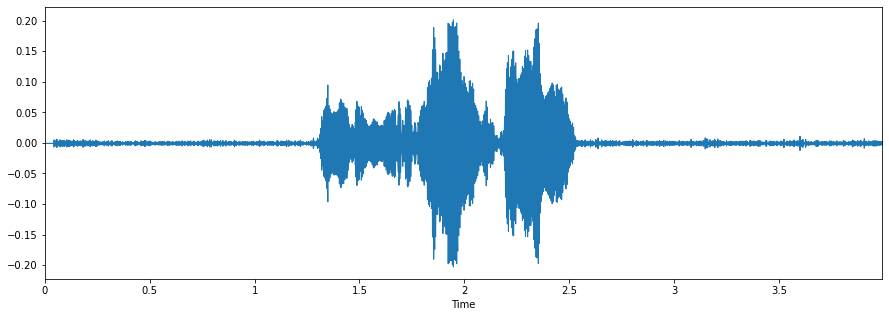

In [281]:

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [282]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [283]:
livedf2= pd.DataFrame(data=livedf2)

In [284]:
livedf2 = livedf2.stack().to_frame().T

In [285]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-29.957461,-29.815687,-30.055693,-29.429149,-27.383947,-26.01119,-27.828768,-28.019281,-25.707064,-25.269475,...,-30.188255,-27.091457,-26.896325,-26.27531,-26.392603,-26.180339,-24.064016,-22.782638,-25.739275,-29.953156


In [286]:
twodim= np.expand_dims(livedf2, axis=2)

In [287]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 0us/step


In [288]:
livepreds

array([[0.07418506, 0.05628146, 0.03737156, 0.14309365, 0.08325108,
        0.04080307, 0.07967646, 0.28806072, 0.06577915, 0.1314978 ]],
      dtype=float32)

In [289]:
livepreds1=livepreds.argmax(axis=1)

In [290]:
liveabc = livepreds1.astype(int).flatten()

In [291]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_fearful'], dtype=object)